# EDT Training With Notebook



In [1]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms


## Define normal pytorch model

In [2]:
from fabric_model import FabricModel

Using pytorch backend.
Using spark scheduler.


In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Define the input with build in pytorch dataset

In [4]:
def getDatasets():
    return (datasets.MNIST('/tmp/data', train=True, download=True, 
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
            datasets.MNIST('/tmp/data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ]))
            )

## Define the training parameter of pytorch

In [5]:
model = Net()  #.to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

## Wrap the mode with EDT model

In [6]:
edt_m = FabricModel(model, getDatasets, F.nll_loss, optimizer)

## visualize the model

/opt/DL/pytorch/lib/python3.6/site-packages/torch/onnx/symbolic.py:130: UserWarning: ONNX export failed on feature_dropout because training mode not supported
  warnings.warn("ONNX export failed on " + op + " because " + msg + " not supported")


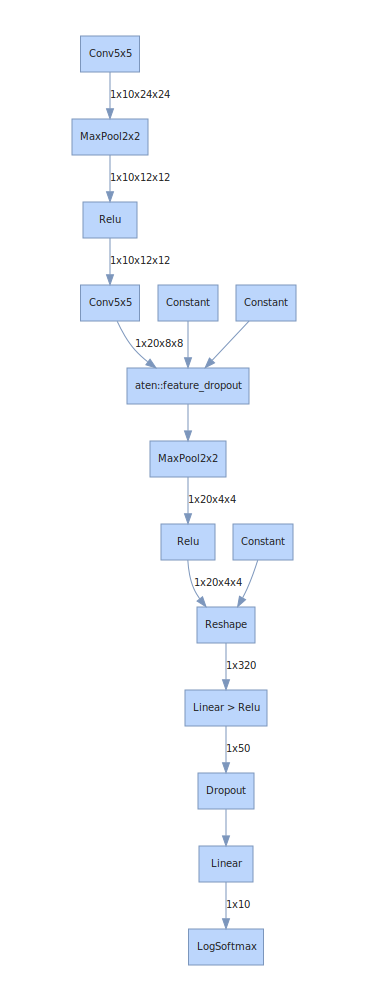

In [6]:
from notebook import plot_model
p = plot_model(model)
p

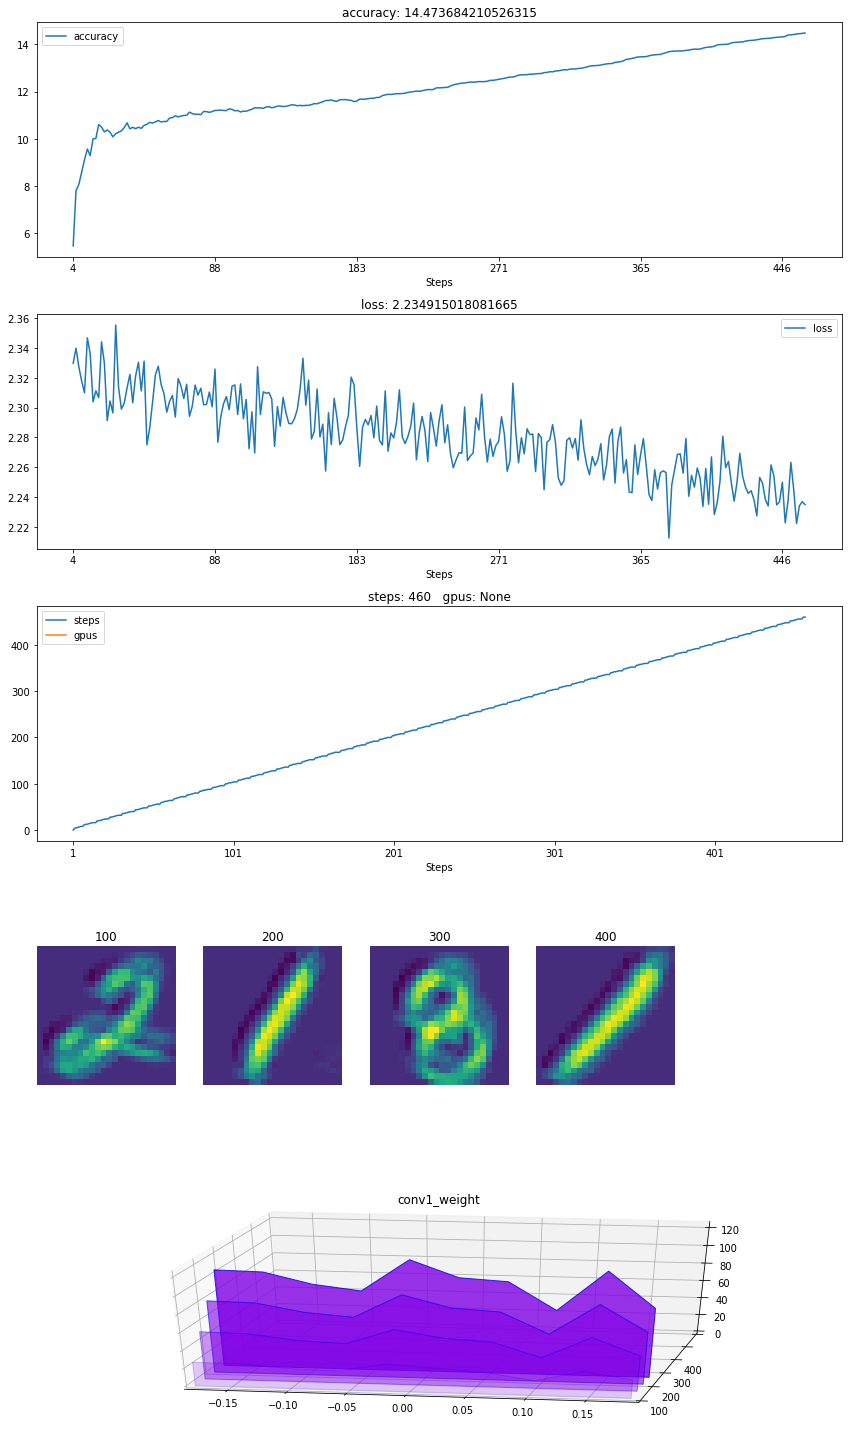

kill process 122490.
kill process 122491.
<=== Epoch 0 End ==> 
--------END TRAINING: completed epoch 0 iteration 469 --------


In [7]:
logger = NotebookLogger2()
#logger.start()
edt_m = FabricModel(model, getDatasets, F.nll_loss, optimizer, driver_logger=logger)
#edt_m = FabricModel(model, getDatasets, F.nll_loss, optimizer)
edt_m.train(1, 128, 2)
#logger.stop()

In [8]:
gpu = edt_m.getGPUInfo()
print ("training happen on:")
for h, g in gpu:
    print('hostname: {}, {}'.format(h,g.name))
    

training happen on:
hostname: aienterprise6.aus.stglabs.ibm.com, Tesla P100-SXM2-16GB
hostname: aienterprise6.aus.stglabs.ibm.com, Tesla P100-SXM2-16GB


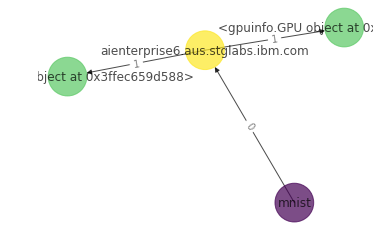

In [13]:
def plot_topology(hostGPUList, appname):
    hosts = set()
    gpus = set()
    appToHost = []
    for h in hostGPUList:
        hosts.add(h[0])
        gpus.add(h[1].name)

    for h in hosts:
        appToHost.append((appname, h))

    val_map = {}
    val_map[appname] = 0.1
    for g in gpus:
        val_map[g]=1.0
    for h in hosts:
        val_map[h]=0.57

    G = nx.DiGraph()
    G.add_edges_from(hostGPUList, weight=1)
    G.add_edges_from(appToHost, weight=0)


    values = [val_map.get(node, 0.45) for node in G.nodes()]

    edge_labels=dict([((u,v,),d['weight']) for u,v,d in G.edges(data=True)])
    red_edges = [appToHost]
    edge_colors = ['black' if not edge in red_edges else 'red' for edge in G.edges()]

    pos=nx.spring_layout(G)
    nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels ,alpha=0.5)
    nx.draw(G,pos, node_color = values, node_size=1500,edge_color=edge_colors, \
            edge_cmap=plt.cm.Reds, with_labels=True,alpha=0.7)
    pylab.show()
    
plot_topology(edt_m.getGPUInfo(), 'mnist')